# Land Cover Classification Model Development

## Setup

### Installation

In [ ]:
!pip -q install geopandas
!pip -q install geojson
!pip -q install --upgrade folium
!pip -q install geemap
!pip -q install rasterio
!pip -q install tqdm
!pip -q install fastai

     |████████████████████████████████| 972kB 7.7MB/s 
     |████████████████████████████████| 14.8MB 178kB/s 
     |████████████████████████████████| 6.5MB 62.1MB/s 
     |████████████████████████████████| 102kB 6.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.11.0 which is incompatible.
     |████████████████████████████████| 389kB 8.2MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 153kB 29.2MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 983kB 23.9MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 225kB 39.9MB/s 
     |████████████████████████████████| 1.9MB 48.8MB/s 
     |████████████████████████████████| 5.1MB 59.1MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 122kB 44.3MB/s 
     |████████████████████████████████| 552kB 59.3MB/s 

### Imports

In [ ]:
from datetime import datetime

from fastai import *
from fastai.vision import *

import os
from tqdm import tqdm
import pandas as pd
import geopandas as gpd

from matplotlib.pyplot import imshow
from skimage import io

import rasterio as rio
import rasterio.mask
from rasterio.plot import show
from rasterio import windows
from shapely.geometry import box

SEED = 42

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets

### Adjust Eurosat labels to KRC ones

In [ ]:
'''Note that only 5 classes are assigned, as nothing found equivalent to 'bare soil'
- Eurosat : ['Industrial', 'Pasture', 'River', 'Forest', 'AnnualCrop', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'SeaLake']
- KRC : cropland, pastureland, baresoil, open water, forestland and others. 
'''

def getKRCLabel(label):

  #if (label=='Highway' or label=='Industrial' or label=='Residential' or label=='HerbaceousVegetation'):
    #new_label = 'Otherland'

  if (label=="SeaLake" or label=="River"):
    new_label = "Water"

  elif (label=="AnnualCrop" or label=="PermanentCrop"):
    new_label = "Cropland"

  elif (label=="Forest"):
    new_label = "Forestland"

  elif (label=="Pasture"):
    new_label = "Pastureland"

  else:
    new_label = "Otherland"

  return new_label

### File Locations

In [ ]:
def get_data_dict(data_dir):
    df = pd.DataFrame(columns=['path', 'label'])

    for (_, labels, _) in os.walk(data_dir):
        for label in labels:

            label_dir = data_dir + label + '/'

            for (_, _, files) in os.walk(label_dir):
                for file in files:

                  df = df.append({'path': label_dir + file, 'label': label}, ignore_index=True)

    #Rename labels
    for index,row in df.iterrows():

      new_label = getKRCLabel(row['label'])
      df.loc[index,'label'] = new_label

    return df

In [ ]:
data_dir_rgb = 'drive/My Drive/EuroSAT/2750/'

df_rgb = get_data_dict(data_dir_rgb)
df_rgb.head(5)

,path,label
0,drive/My Drive/EuroSAT/2750/SeaLake/SeaLake_23...,Water
1,drive/My Drive/EuroSAT/2750/SeaLake/SeaLake_90...,Water
2,drive/My Drive/EuroSAT/2750/SeaLake/SeaLake_12...,Water
3,drive/My Drive/EuroSAT/2750/SeaLake/SeaLake_15...,Water
4,drive/My Drive/EuroSAT/2750/SeaLake/SeaLake_35...,Water


In [ ]:
gk = df_rgb.groupby('label').nunique()
gk

,path
label,
Cropland,5510
Forestland,3010
Otherland,11000
Pastureland,2000
Water,5500


### Generate Train/Val Datasets

In [ ]:
imagenet_stats = (
    [0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225]
)

def get_ImageDataBunch_RGB(df, tfms, valid_pct=0.2):
    data = ImageDataBunch.from_df(
        path='', 
        df=df, 
        ds_tfms=tfms, 
        valid_pct=valid_pct, 
        seed=SEED
    ).normalize(imagenet_stats)
    return data

In [ ]:
tfms = get_transforms(
    do_flip=True, flip_vert=True, max_rotate=None, max_zoom=0,
    max_lighting=None, max_warp=None, p_affine=0, p_lighting=0
)
data_rgb = get_ImageDataBunch_RGB(df_rgb, tfms)
data_rgb

ImageDataBunch;

Train: LabelList (21616 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Water,Water,Water,Water,Water
Path: .;

Valid: LabelList (5404 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Otherland,Water,Cropland,Cropland,Otherland
Path: .;

Test: None

### Visualize Data

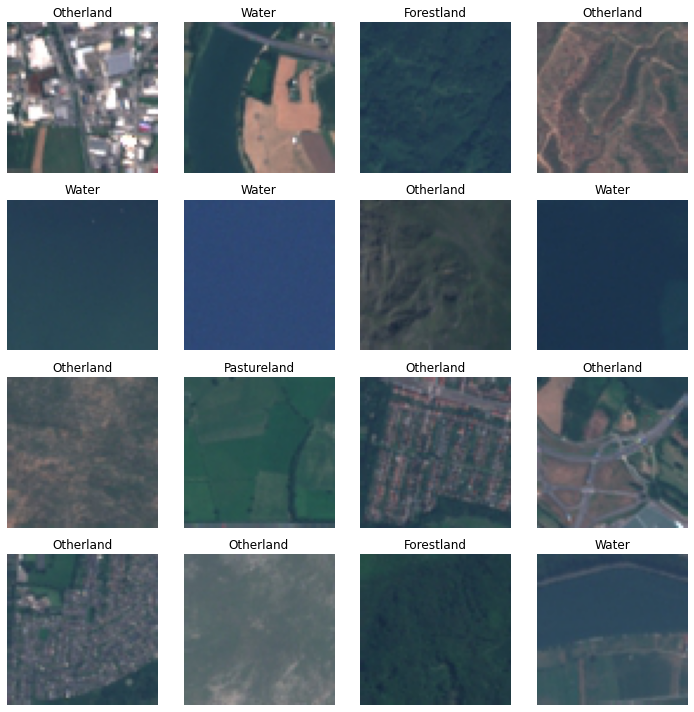

In [ ]:
data_rgb.show_batch(rows=4, figsize=(10, 10))

## Model Development

### Instantiate Model

In [ ]:
data_rgb.classes

['Cropland', 'Forestland', 'Otherland', 'Pastureland', 'Water']

In [ ]:
len(data_rgb.classes)

5

In [ ]:
import torchsummary
from torchvision import models

defaults.device = torch.device('cuda')

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(data_rgb.classes))
model = model.to(defaults.device)

torchsummary.summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

### Train Model

In [ ]:
model_file_dir = "./drive/My Drive/models/resnetEurosat/"
if not os.path.exists(model_file_dir):
    os.makedirs(model_file_dir)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


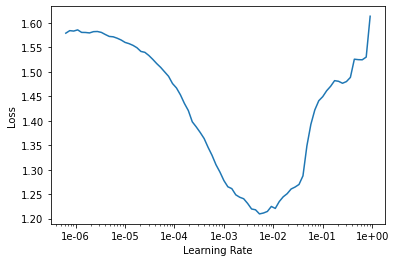

In [ ]:
learn = Learner(data_rgb, model, metrics=[accuracy], model_dir=model_file_dir).mixup()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.654594,0.316948,0.901924,1:01:36
1,0.585544,0.158163,0.964656,00:53
2,0.503184,0.114396,0.978904,00:50


In [ ]:
learn.save('resnet50eurosat90percent')

### Save Model

In [ ]:
if not os.path.isdir(model_file_dir):
    os.mkdir(model_file_dir)
model_filename = '{}export.pkl'.format(model_file_dir)

learn.export(model_filename)
model_filename

'./drive/My Drive/models/resnetEurosat/export.pkl'

### Visualize Results

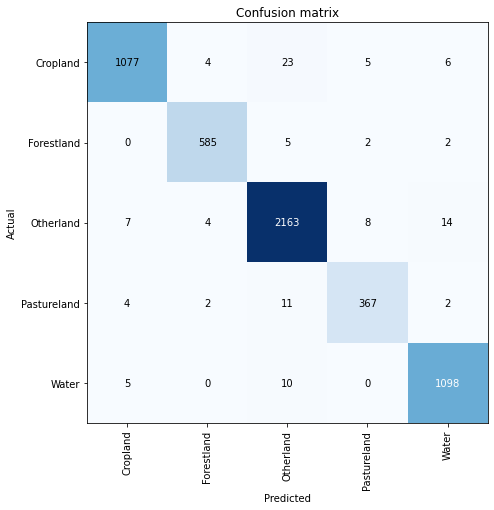

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7, 7))

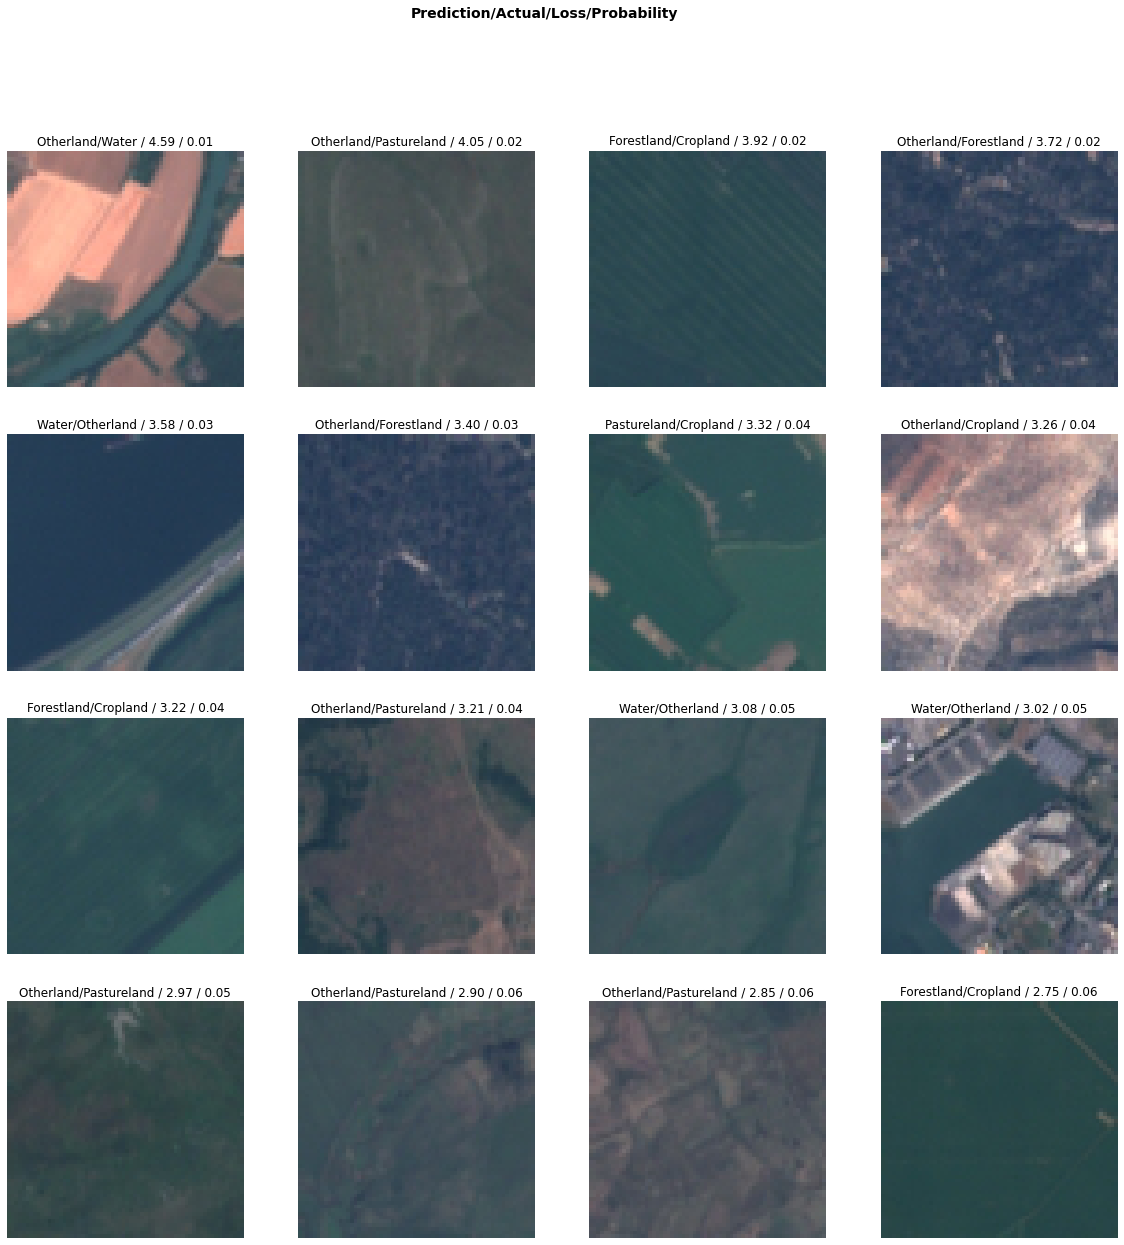

In [ ]:
interp.plot_top_losses(16, figsize=(20,20))

## Inference

In [ ]:
learn = load_learner(model_file_dir)

### Single EuroSAT Image Prediction

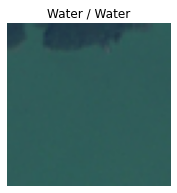

In [ ]:
#To compare ground truth vs prediction, but this maybe misleading as this image could have already been in the training
from skimage import io

index = random.randint(0, 10000)
image_path = df_rgb.iloc[index].path

raw = io.imread(image_path)
img = open_image(image_path)

pred = learn.predict(img)
title = '{} / {}'.format(str(data_rgb.classes[pred[1]]), str(df_rgb.iloc[index].label))
img.show(title=title)

In [ ]:
'''
def predict_crop(image, shape, show=False):
    with rio.open(image) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        
        if np.sum(out_image) > 0:
          out_meta = src.meta
          out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
          })

          temp_tif = './drive/My Drive/Omdena/temp.tif'
          with rasterio.open(temp_tif, "w", **out_meta) as dest:
              dest.write(out_image)

          crop_image = crop(open_image(temp_tif), 64, 0, 0)
          pred = learn.predict(crop_image)
          label = str(data_rgb.classes[int(pred[1])])
          
          if show: 
            crop_image.show(title=label)

          return label

    return None
'''